In [ ]:
### Throw this on Google Colab
### Make sure to set Runtime to "GPU" --- even with the free version there should not be any issues, otherwise some experiments will take a while.

In [9]:
!pip install pykeops > install.log

import pykeops

###necessary because of a "deprecated" issue in the pykeops code that obstructs the output in the experiments below
###if you're ok with seeing these come up, you can comment out the this line
pykeops.set_verbose(False)

###necessary imports
import numpy as np
import torch
from scipy import linalg
from scipy.linalg import sqrtm, inv, det
from math import *

import matplotlib.pyplot as plt
import statsmodels.api as sm

import pickle
import time

from functools import partial

#####
# Code here is taken from: https://gitlab.com/proussillon/wasserstein-estimation-sinkhorn-divergence with some small modifications
##### 
try:  # Import the keops library, www.kernel-operations.io
    from pykeops.torch import generic_logsumexp
    from pykeops.torch import generic_sum
    from pykeops.torch import Genred
    keops_available = True
except:
    keops_available = False
    
#Use gpu if available
use_cuda = torch.cuda.is_available()
dtype    = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor
dtypeint = torch.cuda.LongTensor if use_cuda else torch.LongTensor

def log_weights(α):
    α_log = α.log()
    α_log[α <= 0] = -100000
    return α_log

def sinkhorn_loop( softmin, marg_x, α_log, β_log, C_xy, C_yx, ε, Nits_max = None):
#sinkhorn_loop performs the Sinkhorn iterations until convergence.
    Nits = 1
    N, D = C_xy[0].shape
    M, D = C_xy[1].shape
    # Start with a decent initialization for the dual vectors:
    v = softmin(ε, C_yx, α_log )  # OT(α,β) wrt. a
    u = softmin(ε, C_xy, β_log )  # OT(α,β) wrt. b
    
    err = (torch.abs(marg_x(ε, C_yx, v, u)/N-1.)).sum()/M
    err_marginal = [err]

    if Nits_max == None:
        Nits_max = 5*10**3

    while (Nits< Nits_max) and (err > 5*10**(-5) or Nits < 2 ):
        Nits += 1
        # "Coordinate ascent" on the dual problems:
        v = softmin(ε, C_yx, α_log + u/ε )  # OT(α,β) wrt. a
        u = softmin(ε, C_xy, β_log + v/ε )  # OT(α,β) wrt. b
        if Nits % 50 == 0:
          err = (torch.abs(marg_x(ε, C_yx, v, u)/N-1.)).sum()/M
          err_marginal.append(err)
    u_t, v_t = u, v
    return u_t, v_t

def T(blur, alpha, x, beta, y, sym=False,Nits_max=None,keops_available = keops_available):
        
    n, d = x.shape
    Loss =  loss_sinkhorn_online(d, p=2, blur=blur, sym=sym,Nits_max = Nits_max, keops_available = keops_available)
    u_ab, v_ab = Loss( alpha, x, beta, y )
            
    return u_ab, v_ab

# ==============================================================================
#                          backend == "tensorized"
# ==============================================================================

def squared_distances(x, y):
    D_xx = (x*x).sum(-1).unsqueeze(1)  # (N,1)
    D_xy = torch.matmul( x, y.permute(1,0) )  # (N,D) @ (D,M) = (N,M)
    D_yy = (y*y).sum(-1).unsqueeze(0)  # (1,M)
    return D_xx - 2*D_xy + D_yy

def softmin_tensorized():
    def softmin(ε, C_xy, g):
        x, y = C_xy
        return - ε * ( g[None,:] - squared_distances(x,y)/ε ).logsumexp(1).view(-1)
    return softmin

def lse_tensorized():
    def lse(ε,C_xy,g):
        x,y = C_xy
        return ( g[None,:] - squared_distances(x,y)/ε ).logsumexp(1).view(-1)
    return lse

def marginal_tensorized():
    #print("Tensorized version")
    def marginal(ε, C_xy, u, v):
        x, y = C_xy
        marginal_i = torch.exp( (u[:,None] + v[None,:] - squared_distances(x,y))/ε ).sum(dim = 1)
        return marginal_i
    return marginal

# ==============================================================================
#                          backend == "online"
# ==============================================================================

cost_formulas = {
    1 : "Norm2(X-Y)",
    2 : "(SqDist(X,Y))",
}

def softmin_online(ε, C_xy, f_y, log_conv=None):
    x, y = C_xy
    # KeOps is pretty picky on the input shapes...
    return - ε * log_conv( x, y, f_y.view(-1,1), torch.Tensor([1/ε]).type_as(x) ).view(-1)

def lse_online(ε,C_xy, f_y, log_conv=None):
    x, y = C_xy
    # KeOps is pretty picky on the input shapes...
    return log_conv( x, y, f_y.view(-1,1), torch.Tensor([1/ε]).type_as(x) ).view(-1)

def marginal_online(ε, C_xy, b_x, a_y, log_conv=None):
    x,y = C_xy
    
    return log_conv( torch.Tensor([1/ε]).type_as(x), x, y, b_x.view(-1,1), a_y.view(-1,1) )


def keops_OT_plan(D, dtype="float32"):
        
    OT_plan = Genred('Exp( (F_i + G_j - SqDist(X_i,Y_j)) * E )', # F(g,x,y,b) = exp( -g*|x-y|^2 ) * b
                       ['E = Pm(1)',          # First arg  is a parameter,    of dim 1
                        'X_i = Vi({})'.format(D),          # Second arg is indexed by "i", of dim 3
                        'Y_j = Vj({})'.format(D),          # Third arg  is indexed by "j", of dim 3
                        'F_i = Vi(1)',  # 4th arg: one scalar value per line
                        'G_j = Vj(1)'],         # Fourth arg is indexed by "j", of dim 2
                       reduction_op='Sum',
                       axis=1)                # Summation over "j"

    return OT_plan

def keops_lse(cost, D, dtype="float32"):
    log_conv = generic_logsumexp("( B - (P * " + cost + " ) )",
                                 "A = Vi(1)",
                                 "X = Vi({})".format(D),
                                 "Y = Vj({})".format(D),
                                 "B = Vj(1)",
                                 "P = Pm(1)",
                                 dtype = dtype)
    return log_conv



def loss_sinkhorn_online(dim, p=2, blur =.05, sym=False,Nits_max=None, acceleration = False, keops_available = True):
    
    cost = cost_formulas[p]
    
    if keops_available:
        softmin = partial( softmin_online, log_conv = keops_lse(cost, dim, dtype="float32") ) 
        marg_x = partial( marginal_online, log_conv = keops_OT_plan(dim, dtype="float32" ) )
        lse_ = partial( lse_online, log_conv=keops_lse(cost,dim,dtype="float32"))

    else:
        softmin = softmin_tensorized()
        marg_x = marginal_tensorized()
        lse_ = lse_tensorized()

    def loss(α, x, β, y):
        # The "cost matrices" are implicitely encoded in the point clouds,
        # and re-computed on-the-fly
        C_xy, C_yx = ( (x, y.detach()), (y, x.detach()) )
        u, v = sinkhorn_loop(softmin, marg_x, log_weights(α), log_weights(β),C_xy, C_yx, blur, Nits_max = Nits_max)
        return u,v

    return loss

#########################
### OT map estimators ###
#########################
def T_epsn(x,yz,v,blur):
    M = squared_distances(x,yz)
    K = -M/blur + v/blur
    gammaz = -torch.max(K,dim=1)[0]
    K_shift = K + gammaz.reshape(-1,1)
    exp_ = torch.exp(K_shift)
    top_ = torch.matmul(exp_ ,yz)
    bot_ = exp_.sum(axis=1)
    fast = top_.T/bot_
    return fast

###debiased estimator
def T_D_epsn(x,xz,yz,v,v_mu,blur):
    ot_mu = T_epsn(x, xz, v_mu, blur)
    ot_est = T_epsn(x, yz, v, blur)
    ot_debiased = ot_est + (x.T - ot_mu)
    return ot_debiased

In [10]:
###sample transport maps

def OT_splitting(x,r=0):
    y = x.clone()
    y[:,r] = y[:,r] + 2*torch.sign(x[:,r])
    return y

def SP_der(x,g=50):
    return torch.exp(x*g)/(1+torch.exp(x*g))

def OT_splitting_smooth(x,r=0):
    y = x.clone()
    y[:,r] = y[:,r] + 2*(2*SP_der(x[:,r]) - 1)
    return y

def OT_exp(x):
    return torch.exp(x)

def OT_Linear(x,M,shift):
    return shift.view(-1,1) + torch.matmul(M,x)

### generate samples
def generate_samples_splitting(n,d):
    x = -1 + 2*torch.rand((n,d)).type(dtype)
    y = OT_splitting(x)
    return 1/n*torch.ones(x.shape[0]).type(dtype), x, 1/n*torch.ones(y.shape[0]).type(dtype), y

def generate_samples_splitting_smooth(n,d):
    x = -1 + 2*torch.rand((n,d)).type(dtype)
    y = OT_splitting_smooth(x)
    return 1/n*torch.ones(x.shape[0]).type(dtype), x, 1/n*torch.ones(y.shape[0]).type(dtype), y

def generate_samples_exp(n,d):
    x = -1 + 2*torch.rand((n,d)).type(dtype)
    y = OT_exp(x)
    return 1/n*torch.ones(x.shape[0]).type(dtype), x, 1/n*torch.ones(y.shape[0]).type(dtype), y

def generate_samples_Omega(n,d):
    x = -1 + 2*torch.rand((n,d)).type(dtype)
    Omegaii = 0.8 + (0.4/(d-1))*np.arange(d)
    Omega = torch.from_numpy(np.diag(Omegaii)).type(dtype)
    shiftvec = torch.zeros(d).type(dtype)
    target = OT_Linear(x.T,Omega,shiftvec).T
    return 1/n*torch.ones(x.shape[0]).type(dtype), x, 1/n*torch.ones(target.shape[0]).type(dtype), target.contiguous()

def sampling_gaussians(A,B):#sampling Gaussian densities with covariances A and B
    def generate_samples_gaussians(n,d):
        sqrtA, sqrtB = linalg.sqrtm( A ), linalg.sqrtm( B )
        InvsqrtA, InvsqrtB =  linalg.inv( sqrtA ), linalg.inv( sqrtB )
        transport_plan = InvsqrtA @ linalg.sqrtm( sqrtA @ B @ sqrtA ) @ InvsqrtA
        x_np = np.random.multivariate_normal(np.zeros(d), A, n)
        y_np = (transport_plan @ (x_np.T)).T
        x = torch.from_numpy(x_np).type(dtype)
        y = torch.from_numpy(y_np).type(dtype)
        return 1/n*torch.ones(x.shape[0]).type(dtype), x, 1/n*torch.ones(y.shape[0]).type(dtype), y.contiguous()
    return generate_samples_gaussians

def sampling_elliptic(A,B):#sampling elliptical densities with support defined by A and B
    sqrtA, sqrtB = linalg.sqrtm( A ), linalg.sqrtm( B )
    InvsqrtA, InvsqrtB =  linalg.inv( sqrtA ), linalg.inv( sqrtB )
    transport_plan = InvsqrtA @ linalg.sqrtm( sqrtA @ B @ sqrtA ) @ InvsqrtA
    def generate_samples_elliptic(n,d):
        x = np.random.randn(n, d)
        U_x= x / np.sqrt( (x*x).sum(axis = 1) )[:, None]        
        R_x = np.abs( np.arctan( 0.5*np.random.randn(n) ) )**(1/d) * np.sqrt(d/var_est) # radial profile

        X = R_x[:,None]*U_x
        X = X @ linalg.sqrtm(A)
        Y = (transport_plan@X.T).T
        return 1/n*torch.ones(X.shape[0]).type(dtype), torch.from_numpy(X).type(dtype), 1/n*torch.ones(Y.shape[0]).type(dtype), torch.from_numpy(Y).type(dtype).contiguous()
    return generate_samples_elliptic



def pick_dim_elliptic(d):
    #### used same examples as https://gitlab.com/proussillon/wasserstein-estimation-sinkhorn-divergence for d=2,5,10
    if d == 2:
        A = np.diag([1/4, 1.])/(5/4)
        B = np.diag([1., 1/4])/(5/4)
    elif d == 5:
        A = np.array([[ 0.16978762,  0.0079066 , -0.00305658,  0.06233269, -0.03864145],
           [ 0.0079066 ,  0.13422136,  0.06630608,  0.00628961, -0.03833828],
           [-0.00305658,  0.06630608,  0.25770963,  0.0029424 , -0.08436292],
           [ 0.06233269,  0.00628961,  0.0029424 ,  0.23765334, -0.00284936],
           [-0.03864145, -0.03833828, -0.08436292, -0.00284936,  0.20062805]])

        B = np.array([[ 1.79895465e-01,  4.84058250e-02, -2.50061531e-03,
             2.20434323e-02,  5.73844141e-02],
           [ 4.84058250e-02,  2.69097871e-01, -1.75206915e-05,
             2.56719143e-03, -1.31661786e-02],
           [-2.50061531e-03, -1.75206915e-05,  1.96945587e-01,
            -5.04297934e-03, -1.39942116e-02],
           [ 2.20434323e-02,  2.56719143e-03, -5.04297934e-03,
             1.92592626e-01,  3.20464431e-02],
           [ 5.73844141e-02, -1.31661786e-02, -1.39942116e-02,
             3.20464431e-02,  1.61468450e-01]])
    elif d == 10:

        A =np.array([[ 0.13080849, -0.01446892,  0.0255167 , -0.00093837,  0.01417889,
            0.00050918, -0.00165703,  0.02185116, -0.00394014, -0.01383617],
          [-0.01446892,  0.08376309,  0.00242143, -0.01078231, -0.01636503,
            0.00362786,  0.01587431,  0.00201639, -0.01385313, -0.00411275],
          [ 0.0255167 ,  0.00242143,  0.08097622, -0.00292326,  0.00773311,
            0.00649384,  0.00023523, -0.00044357,  0.01288671, -0.00261004],
          [-0.00093837, -0.01078231, -0.00292326,  0.11478521,  0.01188897,
           -0.01472258,  0.00796273, -0.01584829, -0.00392142,  0.00243829],
          [ 0.01417889, -0.01636503,  0.00773311,  0.01188897,  0.08300107,
           -0.01375438, -0.01388335, -0.00470122, -0.00733626,  0.00699454],
          [ 0.00050918,  0.00362786,  0.00649384, -0.01472258, -0.01375438,
            0.09535711,  0.00308296, -0.00015572,  0.01475986, -0.00422127],
          [-0.00165703,  0.01587431,  0.00023523,  0.00796273, -0.01388335,
            0.00308296,  0.10301467,  0.01098607, -0.01886993,  0.00795968],
          [ 0.02185116,  0.00201639, -0.00044357, -0.01584829, -0.00470122,
           -0.00015572,  0.01098607,  0.10558614, -0.00494307, -0.00258787],
          [-0.00394014, -0.01385313,  0.01288671, -0.00392142, -0.00733626,
            0.01475986, -0.01886993, -0.00494307,  0.10551872,  0.00204018],
          [-0.01383617, -0.00411275, -0.00261004,  0.00243829,  0.00699454,
           -0.00422127,  0.00795968, -0.00258787,  0.00204018,  0.09718929]])
    
        B = np.array([[ 7.75949387e-02, -1.22891559e-02,  3.16922358e-03,
            5.86716252e-04, -1.75432495e-03, -8.10772773e-03,
            4.00637735e-03,  1.83156824e-03,  5.05200600e-03,
            6.29529581e-03],
          [-1.22891559e-02,  1.12330689e-01, -2.44473470e-03,
           -8.20348272e-03, -7.57012125e-03,  1.22460308e-02,
           -1.56405452e-02, -1.50616466e-02, -1.55995277e-02,
           -1.53127463e-02],
          [ 3.16922358e-03, -2.44473470e-03,  1.16861869e-01,
           -1.85050680e-02, -2.21735821e-02, -1.16717587e-02,
           -1.94993567e-03, -4.56195454e-03, -6.05324397e-03,
           -9.78533996e-05],
          [ 5.86716252e-04, -8.20348272e-03, -1.85050680e-02,
            9.35400682e-02,  1.26015862e-02,  1.50215116e-04,
            1.96610473e-02,  7.65060699e-03,  1.23575674e-02,
           -3.85341357e-03],
          [-1.75432495e-03, -7.57012125e-03, -2.21735821e-02,
            1.26015862e-02,  1.18096499e-01, -9.64843042e-03,
            1.72141712e-03, -8.14612679e-03,  8.03096448e-03,
            1.92778413e-02],
          [-8.10772773e-03,  1.22460308e-02, -1.16717587e-02,
            1.50215116e-04, -9.64843042e-03,  9.40253576e-02,
            6.80922122e-04, -2.00883121e-02, -1.02542147e-02,
           -2.00624015e-03],
          [ 4.00637735e-03, -1.56405452e-02, -1.94993567e-03,
            1.96610473e-02,  1.72141712e-03,  6.80922122e-04,
            1.17807211e-01, -2.44277349e-04, -8.13799923e-03,
            9.70970780e-03],
          [ 1.83156824e-03, -1.50616466e-02, -4.56195454e-03,
            7.65060699e-03, -8.14612679e-03, -2.00883121e-02,
           -2.44277349e-04,  9.43794655e-02, -2.16797937e-03,
           -7.26999023e-03],
          [ 5.05200600e-03, -1.55995277e-02, -6.05324397e-03,
            1.23575674e-02,  8.03096448e-03, -1.02542147e-02,
           -8.13799923e-03, -2.16797937e-03,  8.24463022e-02,
            7.10262856e-03],
          [ 6.29529581e-03, -1.53127463e-02, -9.78533996e-05,
           -3.85341357e-03,  1.92778413e-02, -2.00624015e-03,
            9.70970780e-03, -7.26999023e-03,  7.10262856e-03,
            9.29175995e-02]])
    return A,B

In [11]:
######plotting utils#######
import matplotlib
matplotlib.rcParams.update({'font.size': 15})

def CreateEpsComparePlot(file,save=False):
    with open(file, 'rb') as f:
        file1 = pickle.load(f)

    L2_biased=file1['L2_biased_Error']
    L2_debiased=file1['L2_debiased_Error']
    Es = file1['Es']
    Ns = file1['Ns']
    dim = file1['dim']
    data = file1['data']
    title='oneplot_error_for_{}_in_dim_{}'.format(data,dim)    
    eps = Es[0]

    fig = plt.plot(figsize=(8, 5))
    x = np.array(Ns)
    y_b = L2_biased[0,:,:]
    y_db = L2_debiased[0,:,:]

    ###compute the means across the trials
    y_b_means = np.mean(y_b,axis=-1)
    y_db_means = np.mean(y_db,axis=-1)

    ###compute the standard deviation across trials
    y_b_stds = np.std(y_b,axis=-1)
    y_db_stds = np.std(y_db,axis=-1)

    c1='#377eb8' ###biased
    c2='#ff7f00' ###debiased
    ###plotting on logscale
    plt.loglog(x,y_b_means,label='$\hat{T}_\epsilon$',c=c1,linewidth=1.5)
    plt.loglog(x,y_db_means,label='$\hat{T}_\epsilon^D$',c=c2,linewidth=2.5)

    ###plotting error bars on logscale too
    plt.errorbar(x,y_b_means,yerr=y_b_stds,c=c1,linewidth=1.5)
    plt.errorbar(x,y_db_means,yerr=y_db_stds,c=c2,linewidth=2.5)

    plt.grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.5)
    plt.xlabel('$n$')
    plt.ylabel('MSE')
    plt.legend(loc='lower left')

    if save:
        savename = title+'.pdf'
        plt.savefig(savename,bbox_inches='tight')

The following code blocks run the experiments from Section 5.1 of the main paper. 

*Parameters and their meaning*

- N_sampling: # samples for Monte Carlo integration
- Ns: # samples to learn the maps from, should be a list
- numTrials: # of trials to repeat the procedure and generate error bars
- Es: regularization parameter, should be a list with one number
- dim: dimension of the problem (**Note:** dim=2,5,10 only for "Elliptic Contour example")
- data: for file generation, default choices are 'Elliptic', 'splitting', 'splitting_smooth', 'omega', and 'exp'
- Nits_max: max number of iterations for Sinkhorn's algorithm above

eps=0.500000, n=500, trials: 20/20, time=3
eps=0.500000, n=750, trials: 20/20, time=8
eps=0.500000, n=1000, trials: 20/20, time=13
eps=0.500000, n=1250, trials: 20/20, time=18
eps=0.500000, n=1750, trials: 20/20, time=23
eps=0.500000, n=2000, trials: 20/20, time=29
eps=0.500000, n=2500, trials: 20/20, time=36
eps=0.500000, n=3000, trials: 20/20, time=43
eps=0.500000, n=5000, trials: 20/20, time=54
eps=0.500000, n=10000, trials: 20/20, time=76
==== Done 0.500000 epsilon level ====


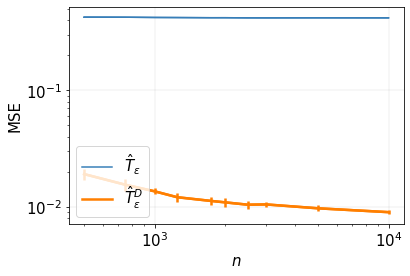

In [12]:
##### Elliptic Contour example ######
N_sampling = 50000
Ns = [500,750,1000,1250, 1750, 2000,2500,3000,5000,10000]
numTrials = 20
Es = [0.5] ### regularization strength
dim = 10 ###dimension of the problem
data = 'Elliptic' ###dataset of choice
Nits_max = 1000 ###num max iterations for sinkhorn algorithm
keops=True

#Estimation of the variance of the distributions --- need this for elliptic example
N_var = 10000000 # choose it large (say 100*nb_samples)
R = np.abs(np.arctan(0.5*np.random.randn(N_var)))**(1/dim)
var_est = (R*R).sum()/N_var 
A,B = pick_dim_elliptic(dim)
generate_samples_ell = sampling_elliptic(A,B)

L2_biased_Error = np.zeros( (len(Es), len(Ns), numTrials))
L2_debiased_Error = np.zeros( (len(Es), len(Ns), numTrials))

tstart=time.time()
for k, lbd in enumerate(Es): ###loop through "Es" though there's only 1
    for i, n in enumerate(Ns): ###loop through "Ns"
        for t in range(numTrials):
              
            ###generate "training" data
            alpha, x, beta, _ = generate_samples_ell(n,dim)
            _, _, _, y = generate_samples_ell(n,dim)
            ###generate  "L^2(P) estimation data"
            alpha2, x2, beta2, ot_t = generate_samples_ell(N_sampling,dim)

            t0 = time.time()
            u_ab, v_ab = T(lbd, alpha, x, beta, y, Nits_max=Nits_max,keops_available = keops)
            u_aa, v_aa = T(lbd, alpha, x, alpha, x, Nits_max=Nits_max,keops_available = keops)

            t_biased = T_epsn(x2,y,v_ab,lbd)
            t_debiased = T_D_epsn(x2, x, y, v_ab, v_aa, lbd)

            ###compute L^2(P) between T and T_eps, and T and T^D_\eps
            L2_biased_Error[k,i,t] = (torch.linalg.norm( (ot_t.T - t_biased),dim=0)**2).mean()
            L2_debiased_Error[k,i,t] = (torch.linalg.norm( (ot_t.T - t_debiased),dim=0)**2).mean()

            if (t+1)%numTrials == 0:
                print('eps=%f, n=%d, trials: %d/%d, time=%d'%(lbd, n,t+1, numTrials, time.time()-tstart))
    print('==== Done %f epsilon level ===='%(lbd))

dic = {'Es': Es, 'dim': dim, 'N_sampling': N_sampling, 'Ns': Ns, 'numTrials': numTrials,
        'L2_biased_Error': L2_biased_Error, 'L2_debiased_Error': L2_debiased_Error, 
         'data': data, 'keops' :keops, 'cuda':use_cuda}

pkl_title = '{}-D-{}_error.pkl'.format(dim,data)
output = open(pkl_title,'wb')
pickle.dump(dic,output)
output.close()

CreateEpsComparePlot('{}-D-{}_error.pkl'.format(dim,data),save=True)

eps=0.500000, n=500, trials: 20/20, time=2
eps=0.500000, n=750, trials: 20/20, time=6
eps=0.500000, n=1000, trials: 20/20, time=10
eps=0.500000, n=1250, trials: 20/20, time=15
eps=0.500000, n=1750, trials: 20/20, time=20
eps=0.500000, n=2000, trials: 20/20, time=25
eps=0.500000, n=2500, trials: 20/20, time=32
eps=0.500000, n=3000, trials: 20/20, time=39
eps=0.500000, n=5000, trials: 20/20, time=50
eps=0.500000, n=10000, trials: 20/20, time=72
==== Done 0.500000 epsilon level ====


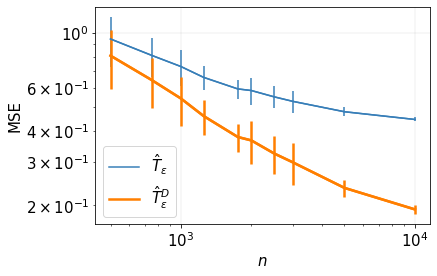

In [13]:
##### Splitting map example ######
N_sampling = 50000
Ns = [500,750,1000,1250, 1750, 2000,2500,3000,5000,10000]
numTrials = 20
Es = [0.5] ### regularization strength
dim = 10 ###dimension of the problem
data = 'splitting' ###dataset of choice
Nits_max = 1000 ###num max iterations for sinkhorn algorithm
keops=True

L2_biased_Error = np.zeros( (len(Es), len(Ns), numTrials))
L2_debiased_Error = np.zeros( (len(Es), len(Ns), numTrials))

tstart=time.time()
for k, lbd in enumerate(Es): ###loop through "Es" though there's only 1
    for i, n in enumerate(Ns): ###loop through "Ns"
        for t in range(numTrials):
              
            ###generate "training" data
            alpha, x, beta, _ = generate_samples_splitting(n,dim)
            _, _, _, y = generate_samples_splitting(n,dim)
            ###generate  "L^2(P) estimation data"
            alpha2, x2, beta2, ot_t = generate_samples_splitting(N_sampling,dim)

            t0 = time.time()
            u_ab, v_ab = T(lbd, alpha, x, beta, y, Nits_max=Nits_max,keops_available = keops)
            u_aa, v_aa = T(lbd, alpha, x, alpha, x, Nits_max=Nits_max,keops_available = keops)

            t_biased = T_epsn(x2,y,v_ab,lbd)
            t_debiased = T_D_epsn(x2, x, y, v_ab, v_aa, lbd)

            ###compute L^2(P) between T and T_eps, and T and T^D_\eps
            L2_biased_Error[k,i,t] = (torch.linalg.norm( (ot_t.T - t_biased),dim=0)**2).mean()
            L2_debiased_Error[k,i,t] = (torch.linalg.norm( (ot_t.T - t_debiased),dim=0)**2).mean()

            if (t+1)%numTrials == 0:
                print('eps=%f, n=%d, trials: %d/%d, time=%d'%(lbd, n,t+1, numTrials, time.time()-tstart))
    print('==== Done %f epsilon level ===='%(lbd))

dic = {'Es': Es, 'dim': dim, 'N_sampling': N_sampling, 'Ns': Ns, 'numTrials': numTrials,
        'L2_biased_Error': L2_biased_Error, 'L2_debiased_Error': L2_debiased_Error, 
         'data': data, 'keops' :keops, 'cuda':use_cuda}

pkl_title = '{}-D-{}_error.pkl'.format(dim,data)
output = open(pkl_title,'wb')
pickle.dump(dic,output)
output.close()

CreateEpsComparePlot('{}-D-{}_error.pkl'.format(dim,data),save=True)

eps=0.500000, n=500, trials: 20/20, time=2
eps=0.500000, n=750, trials: 20/20, time=6
eps=0.500000, n=1000, trials: 20/20, time=10
eps=0.500000, n=1250, trials: 20/20, time=14
eps=0.500000, n=1750, trials: 20/20, time=19
eps=0.500000, n=2000, trials: 20/20, time=24
eps=0.500000, n=2500, trials: 20/20, time=31
eps=0.500000, n=3000, trials: 20/20, time=38
eps=0.500000, n=5000, trials: 20/20, time=49
eps=0.500000, n=10000, trials: 20/20, time=72
==== Done 0.500000 epsilon level ====


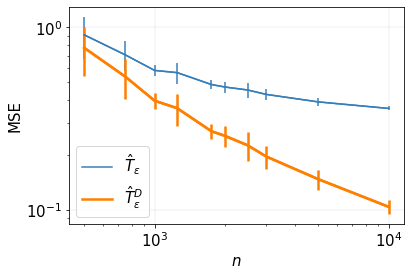

In [14]:
##### Splitting_smooth map example ######
N_sampling = 50000
Ns = [500,750,1000,1250, 1750, 2000,2500,3000,5000,10000]
numTrials = 20
Es = [0.5] ### regularization strength
dim = 10 ###dimension of the problem
data = 'splitting_smooth' ###dataset of choice
Nits_max = 1000 ###num max iterations for sinkhorn algorithm
keops=True

L2_biased_Error = np.zeros( (len(Es), len(Ns), numTrials))
L2_debiased_Error = np.zeros( (len(Es), len(Ns), numTrials))

tstart=time.time()
for k, lbd in enumerate(Es): ###loop through "Es" though there's only 1
    for i, n in enumerate(Ns): ###loop through "Ns"
        for t in range(numTrials):
              
            ###generate "training" data
            alpha, x, beta, _ = generate_samples_splitting_smooth(n,dim)
            _, _, _, y = generate_samples_splitting_smooth(n,dim)

            ###generate  "L^2(P) estimation data"
            alpha2, x2, beta2, ot_t = generate_samples_splitting_smooth(N_sampling,dim)

            t0 = time.time()
            u_ab, v_ab = T(lbd, alpha, x, beta, y, Nits_max=Nits_max,keops_available = keops)
            u_aa, v_aa = T(lbd, alpha, x, alpha, x, Nits_max=Nits_max,keops_available = keops)

            t_biased = T_epsn(x2,y,v_ab,lbd)
            t_debiased = T_D_epsn(x2, x, y, v_ab, v_aa, lbd)

            ###compute L^2(P) between T and T_eps, and T and T^D_\eps
            L2_biased_Error[k,i,t] = (torch.linalg.norm( (ot_t.T - t_biased),dim=0)**2).mean()
            L2_debiased_Error[k,i,t] = (torch.linalg.norm( (ot_t.T - t_debiased),dim=0)**2).mean()

            if (t+1)%numTrials == 0:
                print('eps=%f, n=%d, trials: %d/%d, time=%d'%(lbd, n,t+1, numTrials, time.time()-tstart))
    print('==== Done %f epsilon level ===='%(lbd))

dic = {'Es': Es, 'dim': dim, 'N_sampling': N_sampling, 'Ns': Ns, 'numTrials': numTrials,
        'L2_biased_Error': L2_biased_Error, 'L2_debiased_Error': L2_debiased_Error, 
         'data': data, 'keops' :keops, 'cuda':use_cuda}

pkl_title = '{}-D-{}_error.pkl'.format(dim,data)
output = open(pkl_title,'wb')
pickle.dump(dic,output)
output.close()

CreateEpsComparePlot('{}-D-{}_error.pkl'.format(dim,data),save=True)

eps=0.500000, n=500, trials: 20/20, time=2
eps=0.500000, n=750, trials: 20/20, time=4
eps=0.500000, n=1000, trials: 20/20, time=7
eps=0.500000, n=1250, trials: 20/20, time=11
eps=0.500000, n=1750, trials: 20/20, time=15
eps=0.500000, n=2000, trials: 20/20, time=20
eps=0.500000, n=2500, trials: 20/20, time=26
eps=0.500000, n=3000, trials: 20/20, time=32
eps=0.500000, n=5000, trials: 20/20, time=41
eps=0.500000, n=10000, trials: 20/20, time=62
==== Done 0.500000 epsilon level ====


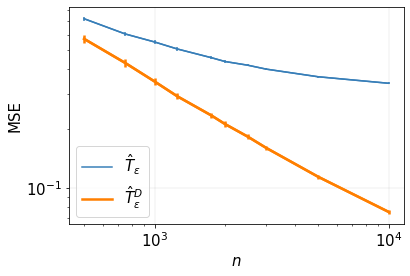

In [15]:
##### Exp map example ######
N_sampling = 50000
Ns = [500,750,1000,1250, 1750, 2000,2500,3000,5000,10000]
numTrials = 20
Es = [0.5] ### regularization strength
dim = 10 ###dimension of the problem
data = 'Exp' ###dataset of choice
Nits_max = 1000 ###num max iterations for sinkhorn algorithm
keops=True

L2_biased_Error = np.zeros( (len(Es), len(Ns), numTrials))
L2_debiased_Error = np.zeros( (len(Es), len(Ns), numTrials))

tstart=time.time()
for k, lbd in enumerate(Es): ###loop through "Es" though there's only 1
    for i, n in enumerate(Ns): ###loop through "Ns"
        for t in range(numTrials):
              
            ###generate "training" data
            alpha, x, beta, _ = generate_samples_exp(n,dim)
            _, _, _, y = generate_samples_exp(n,dim)

            ###generate  "L^2(P) estimation data"
            alpha2, x2, beta2, ot_t = generate_samples_exp(N_sampling,dim)

            t0 = time.time()
            u_ab, v_ab = T(lbd, alpha, x, beta, y, Nits_max=Nits_max,keops_available = keops)
            u_aa, v_aa = T(lbd, alpha, x, alpha, x, Nits_max=Nits_max,keops_available = keops)

            t_biased = T_epsn(x2,y,v_ab,lbd)
            t_debiased = T_D_epsn(x2, x, y, v_ab, v_aa, lbd)

            ###compute L^2(P) between T and T_eps, and T and T^D_\eps
            L2_biased_Error[k,i,t] = (torch.linalg.norm( (ot_t.T - t_biased),dim=0)**2).mean()
            L2_debiased_Error[k,i,t] = (torch.linalg.norm( (ot_t.T - t_debiased),dim=0)**2).mean()

            if (t+1)%numTrials == 0:
                print('eps=%f, n=%d, trials: %d/%d, time=%d'%(lbd, n,t+1, numTrials, time.time()-tstart))
    print('==== Done %f epsilon level ===='%(lbd))

dic = {'Es': Es, 'dim': dim, 'N_sampling': N_sampling, 'Ns': Ns, 'numTrials': numTrials,
        'L2_biased_Error': L2_biased_Error, 'L2_debiased_Error': L2_debiased_Error, 
         'data': data, 'keops' :keops, 'cuda':use_cuda}

pkl_title = '{}-D-{}_error.pkl'.format(dim,data)
output = open(pkl_title,'wb')
pickle.dump(dic,output)
output.close()

CreateEpsComparePlot('{}-D-{}_error.pkl'.format(dim,data),save=True)

eps=0.500000, n=500, trials: 20/20, time=2
eps=0.500000, n=750, trials: 20/20, time=4
eps=0.500000, n=1000, trials: 20/20, time=7
eps=0.500000, n=1250, trials: 20/20, time=11
eps=0.500000, n=1750, trials: 20/20, time=15
eps=0.500000, n=2000, trials: 20/20, time=20
eps=0.500000, n=2500, trials: 20/20, time=26
eps=0.500000, n=3000, trials: 20/20, time=32
eps=0.500000, n=5000, trials: 20/20, time=41
eps=0.500000, n=10000, trials: 20/20, time=62
==== Done 0.500000 epsilon level ====


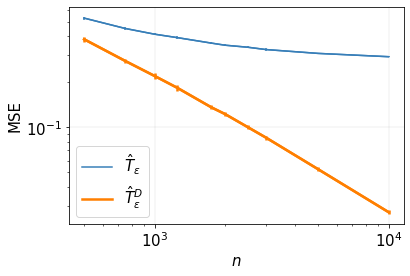

In [16]:
##### omega subplot map example ######
N_sampling = 50000
Ns = [500,750,1000,1250, 1750, 2000,2500,3000,5000,10000]
numTrials = 20
Es = [0.5] ### regularization strength
dim = 10 ###dimension of the problem
data = 'omega' ###dataset of choice
Nits_max = 1000 ###num max iterations for sinkhorn algorithm
keops=True

L2_biased_Error = np.zeros( (len(Es), len(Ns), numTrials))
L2_debiased_Error = np.zeros( (len(Es), len(Ns), numTrials))

tstart=time.time()
for k, lbd in enumerate(Es): ###loop through "Es" though there's only 1
    for i, n in enumerate(Ns): ###loop through "Ns"
        for t in range(numTrials):
              
            ###generate "training" data
            alpha, x, beta, _ = generate_samples_Omega(n,dim)
            _, _, _, y = generate_samples_Omega(n,dim)

            ###generate  "L^2(P) estimation data"
            alpha2, x2, beta2, ot_t = generate_samples_Omega(N_sampling,dim)

            t0 = time.time()
            u_ab, v_ab = T(lbd, alpha, x, beta, y, Nits_max=Nits_max,keops_available = keops)
            u_aa, v_aa = T(lbd, alpha, x, alpha, x, Nits_max=Nits_max,keops_available = keops)

            t_biased = T_epsn(x2,y,v_ab,lbd)
            t_debiased = T_D_epsn(x2, x, y, v_ab, v_aa, lbd)

            ###compute L^2(P) between T and T_eps, and T and T^D_\eps
            L2_biased_Error[k,i,t] = (torch.linalg.norm( (ot_t.T - t_biased),dim=0)**2).mean()
            L2_debiased_Error[k,i,t] = (torch.linalg.norm( (ot_t.T - t_debiased),dim=0)**2).mean()

            if (t+1)%numTrials == 0:
                print('eps=%f, n=%d, trials: %d/%d, time=%d'%(lbd, n,t+1, numTrials, time.time()-tstart))
    print('==== Done %f epsilon level ===='%(lbd))

dic = {'Es': Es, 'dim': dim, 'N_sampling': N_sampling, 'Ns': Ns, 'numTrials': numTrials,
        'L2_biased_Error': L2_biased_Error, 'L2_debiased_Error': L2_debiased_Error, 
         'data': data, 'keops' :keops, 'cuda':use_cuda}

pkl_title = '{}-D-{}_error.pkl'.format(dim,data)
output = open(pkl_title,'wb')
pickle.dump(dic,output)
output.close()

CreateEpsComparePlot('{}-D-{}_error.pkl'.format(dim,data),save=True)